In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

In [13]:
CLASS_NAMES = ["Glioma Tumor", "Meningioma Tumor", "Healthy Brain", "Pituitary Tumor"]
dataset_path = "brain_tumor_dataset"

In [14]:
# 2) Data Augmentation: Strong enough to help differentiate subtle classes
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=[0.8, 1.2],
    shear_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    rescale=1./255,      # We'll stay consistent with rescale=1./255
    validation_split=0.2 # 20% validation
)

In [15]:
# Train / Validation Generators
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical',
    subset='training'
)

Found 1049 images belonging to 4 classes.


In [16]:
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical',
    subset='validation'
)

Found 262 images belonging to 4 classes.


In [17]:
print("Class Indices (alphabetical):", train_generator.class_indices)
# Expect: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'normal': 2, 'pituitary_tumor': 3}

Class Indices (alphabetical): {'glioma_tumor': 0, 'meningioma_tumor': 1, 'normal': 2, 'pituitary_tumor': 3}


In [18]:
# 3) Compute Class Weights to handle potential imbalance
labels = train_generator.classes  # e.g., array([0,0,0,1,1,2,2,3, ...])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(1.0927083333333334), 1: np.float64(1.0704081632653062), 2: np.float64(0.8094135802469136), 3: np.float64(1.0927083333333334)}


In [19]:
# 4) Build the Model (VGG19)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base layers initially

In [20]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])

In [21]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

In [22]:
# 5) Initial Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights_dict
)

c:\Users\niran\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - categorical_accuracy: 0.2351 - loss: 1.5546 - val_categorical_accuracy: 0.4084 - val_loss: 1.3504
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - categorical_accuracy: 0.3174 - loss: 1.4041 - val_categorical_accuracy: 0.2099 - val_loss: 1.3426
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - categorical_accuracy: 0.3888 - loss: 1.3147 - val_categorical_accuracy: 0.4885 - val_loss: 1.2654
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - categorical_accuracy: 0.4889 - loss: 1.2220 - val_categorical_accuracy: 0.4809 - val_loss: 1.2537
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - categorical_accuracy: 0.4872 - loss: 1.1939 - val_categorical_accuracy: 0.4656 - val_loss: 1.2313
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - categorical_accuracy: 0.5203 - loss: 1.1473 - val_categorical_accuracy: 0.4389 - val_loss: 1.2284
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - categorical_accuracy: 0.549

In [28]:
# 6) Fine-Tuning: unfreeze more layers
base_model.trainable = True
for layer in base_model.layers[:15]:
    layer.trainable = False

In [29]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

In [31]:
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights_dict
)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - categorical_accuracy: 0.8383 - loss: 0.4260 - val_categorical_accuracy: 0.7824 - val_loss: 0.6433
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - categorical_accuracy: 0.8808 - loss: 0.3561 - val_categorical_accuracy: 0.7901 - val_loss: 0.6513
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - categorical_accuracy: 0.8939 - loss: 0.3348 - val_categorical_accuracy: 0.7595 - val_loss: 0.6677
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - categorical_accuracy: 0.8704 - loss: 0.3474 - val_categorical_accuracy: 0.7672 - val_loss: 0.7821
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - categorical_accuracy: 0.8700 - loss: 0.3305 - val_categorical_accuracy: 0.7977 - val_loss: 0.5633
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - categorical_accuracy: 0.8984 - loss: 0.3106 - val_categorical_accuracy: 0.8359 - val_loss: 0.4843
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - categorical_accuracy: 0.921

In [32]:
# 7) Evaluate & Save
loss, acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {acc*100:.2f}%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - categorical_accuracy: 0.8072 - loss: 0.9248
Validation Accuracy: 83.59%


In [33]:
model.save("brain_tumor_vgg19_classifier.h5")
print("✅ Model saved as 'brain_tumor_vgg19_classifier.h5'")

✅ Model saved as 'brain_tumor_vgg19_classifier.h5'


In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [36]:
# Function to plot training history
def plot_training_history(history, history_finetune):
    plt.figure(figsize=(12, 5))

Text(0.5, 1.0, 'Model Accuracy')

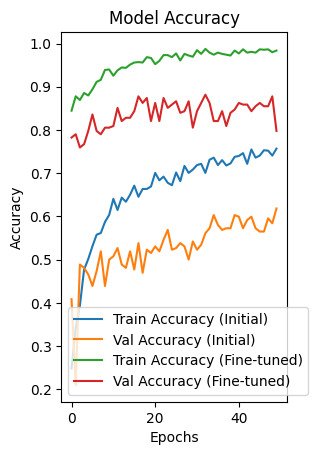

In [37]:
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['categorical_accuracy'], label='Train Accuracy (Initial)')
    plt.plot(history.history['val_categorical_accuracy'], label='Val Accuracy (Initial)')
    plt.plot(history_finetune.history['categorical_accuracy'], label='Train Accuracy (Fine-tuned)')
    plt.plot(history_finetune.history['val_categorical_accuracy'], label='Val Accuracy (Fine-tuned)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

Text(0.5, 1.0, 'Model Loss')

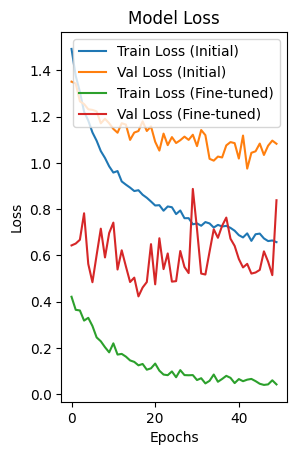

In [39]:
 # Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss (Initial)')
plt.plot(history.history['val_loss'], label='Val Loss (Initial)')
plt.plot(history_finetune.history['loss'], label='Train Loss (Fine-tuned)')
plt.plot(history_finetune.history['val_loss'], label='Val Loss (Fine-tuned)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

In [40]:
plt.show()

In [41]:
# Call the function to plot
plot_training_history(history, history_finetune)

<Figure size 1200x500 with 0 Axes>

In [42]:

# Evaluate model and compute classification metrics
val_generator.reset()
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step


In [8]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import CategoricalAccuracy

# Load the saved model
model = load_model("brain_tumor_vgg19_classifier.h5")

# Recompile the model to ensure correct metrics
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[CategoricalAccuracy()]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {accuracy * 100:.2f}%")


c:\Users\niran\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


82/82 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - categorical_accuracy: 0.9290 - loss: 0.2366
Test Accuracy: 94.74%


In [7]:
import numpy as np
from sklearn.metrics import accuracy_score

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = test_generator.classes

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


82/82 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step
Test Accuracy: 94.74%


Found 1311 images belonging to 4 classes.


c:\Users\niran\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\niran\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step
Confusion Matrix:
[[283   8   1   8]
 [  2 270  10  24]
 [  5   5 390   5]
 [  0   1   0 299]]

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.98      0.94      0.96       300
meningioma_tumor       0.95      0.88      0.92       306
          normal       0.97      0.96      0.97       405
 pituitary_tumor       0.89      1.00      0.94       300

        accuracy                           0.95      1311
       macro avg       0.95      0.95      0.95      1311
    weighted avg       0.95      0.95      0.95      1311



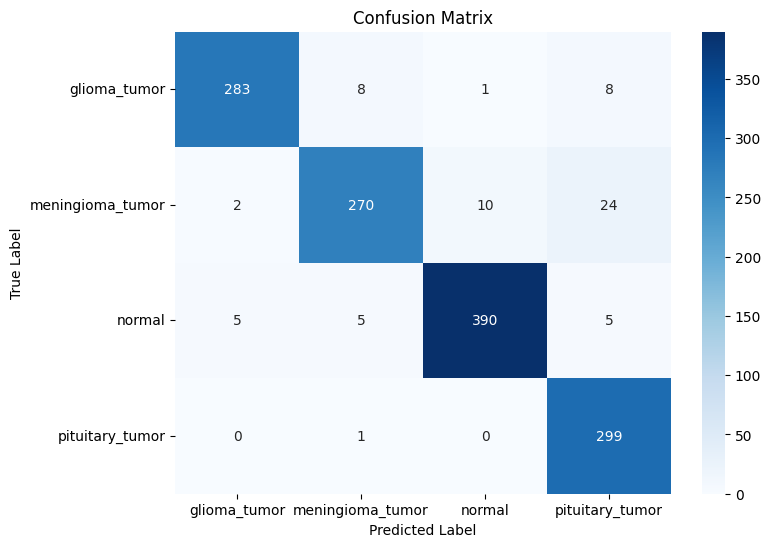

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# Path to your test dataset (structured similar to training: one folder per class)
test_dataset_path = "brain_tumor_dataset"  # Update this path as needed

# Create an ImageDataGenerator for the test set (only rescaling is needed)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test generator; ensure target_size matches training (224x224)
test_generator = test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Important to maintain the order for evaluation
)

# Load the trained model
model = load_model("brain_tumor_vgg19_classifier.h5")

# Predict on the test set
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Get class labels (alphabetical order as per directory names)
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_labels)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()